1. Używane biblioteki

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
from bisect import bisect_left, bisect_right

2. Liniowa funkcja sklejana

2.1 Funkcja kształtu

In [5]:
# x - argument, xs - lista x-ow, i - pozycja w liscie x-ow
def shape_function(x, xs, i):
    
    if i < 0 or i >= len(xs):
        return
    
    # dodatkowo i nie może być równe 0, bo wtedy wyjdziemy poza zakres, a w pythonie odczytamy ostatni element
    if i > 0:
        if x >= xs[i - 1] and x <= xs[i]:
            return (x - xs[i - 1]) / (xs[i] - xs[i - 1])
    
    # dodatkowo i nie moze byc rowne len(xs) -1, bo wtedy by bylo ostatnim elementem i nie mozna by bylo zrobic xs[i + 1]
    if i < len(xs) - 1:
        if x >= xs[i] and x <= xs[i + 1]:
            return (xs[i + 1] - x) / (xs[i + 1] - xs[i])
    
    return 0

2.2 Funkcja sklejana

In [6]:
def linear_spline(x, xs, ys):
    
    # checmy poznać wartość funkcji sklejanej dla danego x-a, czyli trzeba poznać jego pozycję w liście xs
    # do tego będę używać wyszukiwania binarnego, z tego powodu funkcja wymaga posortowanej listy xs
    i = bisect_left(xs, x)
    
    # Wartośc funkcji sklejanej w punkcie x
    s = 0
    
    # Warunek sprawdza, czy bisect_left znalazł x w liście xs
    if i < len(xs):
        
        s += ys[i] * shape_function(x, xs, i)
        
        #To musi być wewnątrz ponieważ trzbea sobie zagwarantować, że x został faktycznie znaleziony przez bisect_left
        if i > 0:
            
            s += ys[i - 1] * shape_function(x, xs, i - 1)
            
    return s
    
    

3. Sześcienna funkcja sklejana

![title](img/img02.png)

In [7]:
#Tak jak powyżej
def h(i, xs):
        return xs[i + 1] - xs[i]

![title](img/img03.png)

In [8]:
def delta_1(i, xs, ys):
    return (ys[i + 1] - ys[i]) / (xs[i + 1] - xs[i]) 

In [9]:
def delta_2(i, xs, ys):
    return (delta_1(i + 1, xs, ys) - delta_1(i, xs, ys)) / (xs[i + 2] - xs[i])

In [10]:
def delta_3(i, xs, ys):
    return (delta_2(i + 1, xs, ys) - delta_2(i, xs, ys)) / (xs[i + 3] - xs[i]) #

![title](img/img04.png)

In [11]:
#Funkcja przygotowuje dwie macierze narazie bez warunków brzegowych
def get_initial_matrix(xs, ys):
    
    n = len(xs)
    
    #Rzędów jest tyle ile sigm, czyli len(xs)
    A = np.zeros(shape=(n, n))
    C = np.zeros(shape=(n, 1))
    
    #Uzupełniam macieraze zgodnie ze wzorem powyżej, oprócz i = 0 oraz i = n, ponieważ tam idą warunku brzegowe
    #Należy zwrócić uwagę, że delty i h są przesunięte o 1 do tyłu ze względu na numerację tablic od 0
    for i in range(1, n - 1):
        A[i][i - 1] = h(i - 1, xs) 
        A[i][i] = 2 * (h(i - 1, xs) + h(i, xs))
        A[i][i + 1] = h(i, xs)
        
        C[i] = delta_1(i, xs, ys) - delta_1(i - 1, xs, ys)
        
    return A, C

Cubic spline boundary - tak jak na obrazku powyżej

In [12]:
def cubic_boundary(A, C, xs, ys):
    
    A[0][0] = -h(0, xs)
    A[0][1] = h(0, xs)
    
    A[-1][-2] = h(len(A) - 2, xs)
    A[-1][-1] = -h(len(A) - 2, xs)
    
    C[0] = (h(0, xs) ** 2) * delta_3(0, xs, ys)
    C[-1] = -(h(len(C) - 2, xs) ** 2) * delta_3(len(C) - 4, xs, ys)
    
    sigma = np.linalg.solve(A, C)
    
    return sigma

Natural cubic spline boundary

![title](img/img05.png)

In [13]:
def natural_cubic_boundary(A, C):
    
    #Ponieważ sigma_i = 1/6 * S_i''(x_i), skoro S_i'' = 0 to sigma tez = 0
    #Dzięki temu warunkowi wystarczy, że rozwiązać n - 2 równań, bo sigma(1) = sigma(n) = 0
    
    A = A[1:-1, 1:-1]
    C = C[1:-1]
    
    sigma = [0, *np.linalg.solve(A, C), 0]
    
    return sigma

![title](img/img01.png)

In [14]:
# boundary_type:
# 0 - cubic_boundary
# 1 - natural_cubic_boundary

def cubic_spline(x, xs, ys, boundary_type):
        
        # tak jak w przypadku linear_spline trzeba poznać pozycję x-a w liście xs
        i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
    
        #Tworzę obie macierze
        A, C = get_initial_matrix(xs, ys)
        sigma = []
        
        if(boundary_type == 0): sigma = cubic_boundary(A, C, xs, ys)
        elif(boundary_type == 1): sigma = natural_cubic_boundary(A, C)
        
        # zgodnie z powyższym wzorem

        b = ( (ys[i + 1] - ys[i]) / h(i, xs) ) - h(i, xs) * (sigma[i + 1] + 2 * sigma[i])
        c = 3 * sigma[i]
        d = (sigma[i + 1] - sigma[i]) / h(i, xs)
        
        return ys[i] + b * (x - xs[i]) + c * ((x - xs[i]) ** 2 ) + d * ((x - xs[i]) ** 3)

4. Kwadratowa funkcja sklejana

![title](img/img06.png)

![title](img/img07.png)

Natural spline boundary

![title](img/img08.png)

In [15]:
class natural_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return 0
        
        return 2 * natural_quadratic_boundary.get_v(i, xs, ys) - natural_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        
        return (( natural_quadratic_boundary.get_b(i + 1, xs, ys) - natural_quadratic_boundary.get_b(i, xs, ys) ) / 
               2 * ( xs[i + 1] - xs[i]))

Clamped spline boundary

![title](img/img09.png)

In [16]:
class clamped_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return clamped_quadratic_boundary.get_v(1, xs, ys)
        
        return 2 * clamped_quadratic_boundary.get_v(i, xs, ys) - clamped_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        
        return (( clamped_quadratic_boundary.get_b(i + 1, xs, ys) - clamped_quadratic_boundary.get_b(i, xs, ys) ) / 
               2 * ( xs[i + 1] - xs[i]))

In [26]:
def quadratic_spline(x, xs, ys, boundary):
    
    i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
    b = boundary.get_b(i, xs, ys)
    c = boundary.get_c(i, xs, ys)
    
    return ys[i] + b * (x - xs[i]) +  c * ((x - xs[i]) ** 2)

5. Punkty testowe

In [18]:
# Zwraca n równomiernie rozprowadzonych punktów w przedziale [a, b]
def get_evenly_distributed(a, b, n = 100):
    
    length = abs(b - a)
    h = length / (n - 1)
    
    return [a + i * h for i in range(n - 1)] + [b]

6. Zadana funkcja

In [19]:
def f(x):
    return 30 + (x**2 / 1.5) - 30 * math.cos(1.5 * x)

f_range_a = -4 * math.pi
f_range_b = 4 * math.pi

7. Analiza

In [20]:
def plot_function(func, range_a, range_b, func_x = None):
    
    if func_x == None:
        func_x = np.linspace(range_a, range_b, 10000)
        
    func_y = [func(func_x[i]) for i in range(len(func_x))]

    plt.plot(func_x, func_y, label = "Zadana funkcja", color = 'blue')

    plt.legend()
    plt.grid(True)
    plt.savefig("zadana_funkcja.png")

In [21]:
# spline_type argument:
# 0 - linear_spline
# 1 - cubic_spline with cubic_boundary
# 2 - cubic_spline with natural_cubic_boundary
# 3 - quadratic_spline with natural_quadratic_boundary
# 4 - quadratic_spline with clamped_quadratic_boundary

def interpolate(spline_type, n, test_points_count, nodes_plot_label = 'Węzły'):
    
    xs = get_evenly_distributed(f_range_a, f_range_b, n)
    ys = [ f(xs[i]) for i in range(len(xs))]

    check_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
    check_y = []

    for i in range(len(check_x)):

        if(spline_type == 0): check_y.append(linear_spline(check_x[i], xs, ys))
        elif(spline_type == 1): check_y.append(cubic_spline(check_x[i], xs, ys, 0))
        elif(spline_type == 2): check_y.append(cubic_spline(check_x[i], xs, ys, 1))
        elif(spline_type == 3): check_y.append(quadratic_spline(check_x[i], xs, ys, natural_quadratic_boundary))
        elif(spline_type == 4): check_y.append(quadratic_spline(check_x[i], xs, ys, clamped_quadratic_boundary))
        

    plot_function(f, f_range_a, f_range_b)
    plt.plot(check_x, check_y, color = 'red', label = "Funkcja interpolująca")
    plt.scatter(xs, ys, color = 'black', label=nodes_plot_label)
    
    plt.legend()
    plt.grid(True)
    #plt.savefig("interpolacja_spline.png")
    plt.show()

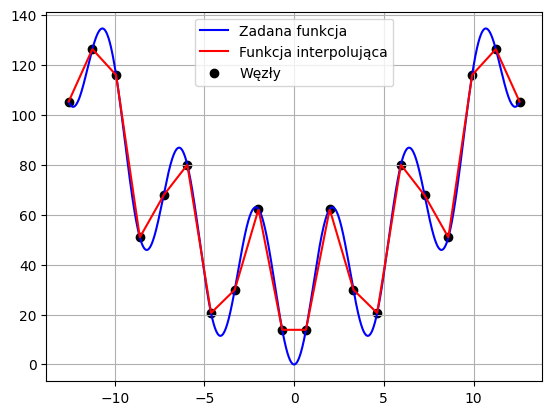

In [22]:
interpolate(0, 20, 1000)

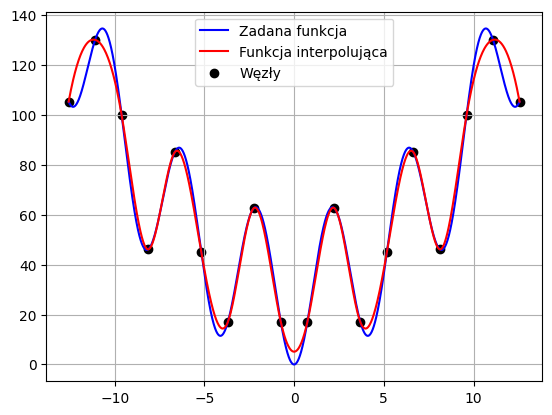

In [23]:
interpolate(1, 18, 1000)

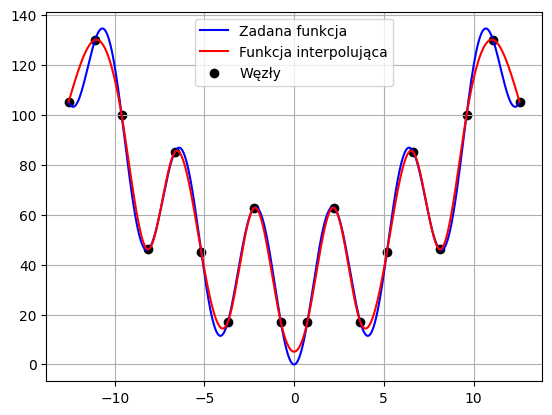

In [24]:
interpolate(2, 18, 1000)

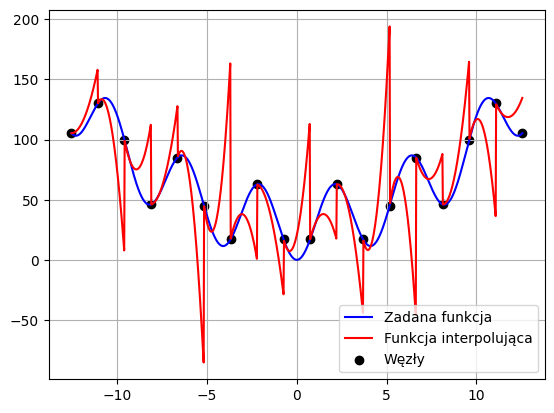

In [27]:
interpolate(3, 18, 1000)

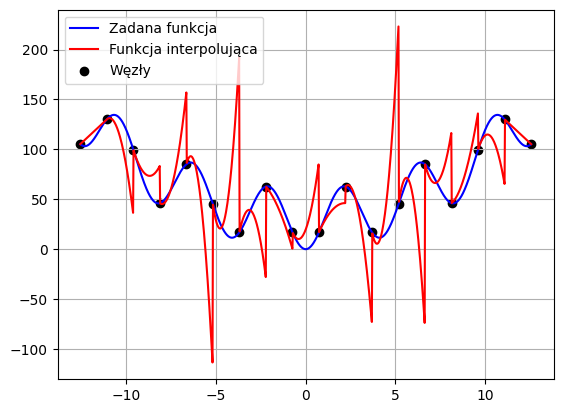

In [28]:
interpolate(4, 18, 1000)